<a href="https://colab.research.google.com/github/pockypoem/orbit-ai/blob/main/SentimentAnalysis_OpiniFilm_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Project Description** <br>
Ini merupakan projek ujian praktek dari domain Natural Language Processing. Dalam hal ini saya memilih untuk membuat sentiment analysis dari berbagai opini masyarakat tentang film yang telah mereka tonton. Dataset berasal dari twitter yang telah saya cantumkan juga linknya di bawah ini. Untuk proses sentiment analysisnya saya menggunakan salah satu algoritma Machine Learning yaitu Support Vector Machine Learning.

Dataset: https://github.com/rizalespe/Dataset-Sentimen-Analisis-Bahasa-Indonesia/blob/master/dataset_tweet_sentiment_opini_film.csv

**Import Library**

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk

nltk.download('stopwords')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import chi2 


# Untuk mempermudah, simpan setiap objek agar dapat digunakan untuk pemodelan maupun deployment. Gunakan library Pickle
import pickle

%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Install library Sastrawi
!pip -q install sastrawi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 KB 14.5 MB/s eta 0:00:00


## 01 Data Acquisition

In [11]:
df = pd.read_csv('dataset_tweet_sentiment_opini_film.csv')
df.head()

,Id,Sentiment,Text Tweet
0,1,negative,Jelek filmnya... apalagi si ernest gak mutu bg...
1,2,negative,Film king Arthur ini film paling jelek dari se...
2,3,negative,@beexkuanlin Sepanjang film gwa berkata kasar ...
3,4,negative,Ane ga suka fast and furious..menurutku kok je...
4,5,negative,"@baekhyun36 kan gua ga tau film nya, lu bilang..."


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Id          200 non-null    int64 
 1   Sentiment   200 non-null    object
 2   Text Tweet  200 non-null    object
dtypes: int64(1), object(2)
memory usage: 4.8+ KB


In [13]:
new_df = df.drop(columns=['Id'])
new_df.head()

,Sentiment,Text Tweet
0,negative,Jelek filmnya... apalagi si ernest gak mutu bg...
1,negative,Film king Arthur ini film paling jelek dari se...
2,negative,@beexkuanlin Sepanjang film gwa berkata kasar ...
3,negative,Ane ga suka fast and furious..menurutku kok je...
4,negative,"@baekhyun36 kan gua ga tau film nya, lu bilang..."


In [14]:
print('Total Jumlah Data:', new_df.shape[0], 'data\n')
print('terdiri dari (Sentiment):')
print('-- [0] Sentiment Posiftive\t:', new_df[new_df.Sentiment == 'positive'].shape[0], 'data')
print('-- [1] Sentiment Negative\t:', new_df[new_df.Sentiment == 'negative'].shape[0], 'data')

Total Jumlah Data: 200 data

terdiri dari (Sentiment):
-- [0] Sentiment Posiftive	: 100 data
-- [1] Sentiment Negative	: 100 data


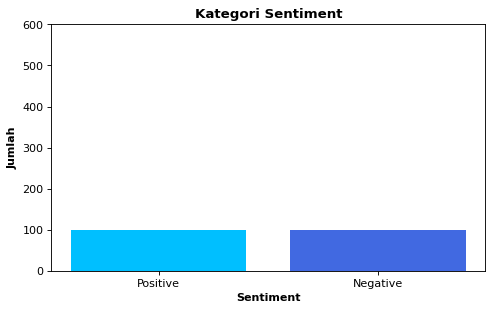

In [15]:
height = new_df['Sentiment'].value_counts()
labels = ('Positive', 'Negative')
y_pos = np.arange(len(labels))

plt.figure(figsize=(7,4), dpi=80)
plt.ylim(0,600)
plt.title('Kategori Sentiment', fontweight='bold')
plt.xlabel('Sentiment', fontweight='bold')
plt.ylabel('Jumlah', fontweight='bold')
plt.bar(y_pos, height, color=['deepskyblue', 'royalblue'])
plt.xticks(y_pos, labels)
plt.show()

## 02 Text Preprocessing

### Case Folding

In [16]:
import re

# Buat fungsi untuk langkah case folding
import re

def casefolding(text):
    # Mengubah teks menjadi lower case
    text = text.lower()   
    # Menghapus URL
    text = re.sub(r'https?://\S+|www\.\S+', '', text)   
    # Menghapus angka
    text = re.sub(r'[-+]?[0-9]+', '', text)
    # Menghapus mentions
    text = re.sub(r'@\w+', '', text) 
    # Menghapus hashtag
    text = re.sub(r'#\w+', '', text)
    # Menghapus retweet
    text = re.sub(r'^RT[\s]+', '', text)
    # Menghapus karakter simbol dan spasi dari kiri dan kanan
    text = re.sub(r'[^\w\s]','', text).strip()
    # Menghapus karakter simbol dan spasi dari tengah string
    text = re.sub(r'\s+', ' ', text) 
    # Mengganti baris baru dengan spasi
    text = re.sub(r'\n', ' ', text)  
    
    return text


In [17]:
raw_sample = new_df['Text Tweet'].iloc[0]
case_folding = casefolding(raw_sample)

print('Raw data\t: ', raw_sample)
print('Case folding\t: ', case_folding)

Raw data	:  Jelek filmnya... apalagi si ernest gak mutu bgt actingnya... film sampah
Case folding	:  jelek filmnya apalagi si ernest gak mutu bgt actingnya film sampah


### Word Normalization

In [18]:
# Download corpus kumpulan slangwords
!wget https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/key_norm.csv

--2023-04-06 11:10:56--  https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/key_norm.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80969 (79K) [text/plain]
Saving to: ‘key_norm.csv’

key_norm.csv        100%[===================>]  79.07K  --.-KB/s    in 0.001s  

2023-04-06 11:10:56 (56.9 MB/s) - ‘key_norm.csv’ saved [80969/80969]



In [19]:
key_norm = pd.read_csv('key_norm.csv')
print(key_norm.head())

key_norm.shape

   _id      singkat       hasil
0    1         abis       habis
1    2       accent     tekanan
2    3       accept      terima
3    4     accident  kecelakaan
4    5  achievement    prestasi


(3720, 3)

In [20]:
def text_normalize(text):
  text = ' '.join([key_norm[key_norm['singkat'] == word]['hasil'].values[0] if (key_norm['singkat'] == word).any() else word for word in text.split()])
  text = str.lower(text)
  return text

In [21]:
raw_sample = new_df['Text Tweet'].iloc[40]
word_normalization = text_normalize(raw_sample)

print('Raw data\t: ', raw_sample)
print('Word Normalization\t: ', word_normalization)

Raw data	:  Kalo Nolan bikin film gak ada perempuan seksi* dan bumbu percintaan selalu hambar.
Word Normalization	:  kalo nolan bikin film tidak ada perempuan seksi* dan bumbu percintaan selalu hambar.


### Filtering (Stopword Removal)

In [25]:
stopwords_ind = stopwords.words('indonesian')

In [26]:
len(stopwords_ind)

758

In [27]:
stopwords_ind.remove('tidak')
stopwords_ind.remove('baik')

In [28]:
def remove_stop_words(text):
  clean_words = []
  text = text.split()
  for word in text:
      if word not in stopwords_ind:
          clean_words.append(word)
  return " ".join(clean_words)

In [29]:
raw_sample = new_df['Text Tweet'].iloc[40]
stopword_removal = remove_stop_words(raw_sample)

print('Raw data\t: ', raw_sample)
print('Word Normalization\t: ', stopword_removal)

Raw data	:  Kalo Nolan bikin film gak ada perempuan seksi* dan bumbu percintaan selalu hambar.
Word Normalization	:  Kalo Nolan bikin film gak perempuan seksi* bumbu percintaan hambar.


### Stemming

In [31]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Buat fungsi untuk langkah stemming bahasa Indonesia
def stemming(text):
  text = stemmer.stem(text)
  return text

In [32]:
raw_sample = new_df['Text Tweet'].iloc[40]
case_folding = casefolding(raw_sample)
stopword_removal = remove_stop_words(case_folding)
text_stemming = stemming(stopword_removal)

print('Raw data\t\t: ', raw_sample)
print('Case folding\t\t: ', case_folding)
print('Stopword removal\t: ', stopword_removal)
print('Stemming\t\t: ', text_stemming)

Raw data		:  Kalo Nolan bikin film gak ada perempuan seksi* dan bumbu percintaan selalu hambar.
Case folding		:  kalo nolan bikin film gak ada perempuan seksi dan bumbu percintaan selalu hambar
Stopword removal	:  kalo nolan bikin film gak perempuan seksi bumbu percintaan hambar
Stemming		:  kalo nol bikin film gak perempuan seksi bumbu cinta hambar


### Text Preprocessing Pipeline

In [33]:
# Buat fungsi untuk menggabungkan seluruh langkah text preprocessing
def text_preprocessing_process(text):
  text = casefolding(text)
  text = text_normalize(text)
  text = remove_stop_words(text)
  text = stemming(text)
  return text

In [34]:
%%time
new_df['text_clean'] = new_df['Text Tweet'].apply(text_preprocessing_process)


CPU times: user 21.8 s, sys: 40.3 ms, total: 21.8 s
Wall time: 22.3 s


### Data Transformation

In [35]:
new_df["Sentiment"][new_df['Sentiment'] == 'negative'] = 0
new_df["Sentiment"][new_df['Sentiment'] == 'positive'] = 1
new_df.head()

,Sentiment,Text Tweet,text_clean
0,0,Jelek filmnya... apalagi si ernest gak mutu bg...,jelek film si ernest tidak mutu banget actingn...
1,0,Film king Arthur ini film paling jelek dari se...,film king arthur film jelek cerita king arthur
2,0,@beexkuanlin Sepanjang film gwa berkata kasar ...,film gwa kasar bapak
3,0,Ane ga suka fast and furious..menurutku kok je...,tidak suka fast and furiousmenurutku jelek ya ...
4,0,"@baekhyun36 kan gua ga tau film nya, lu bilang...",tidak tau film nya bilang perang perang perang...


In [36]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Sentiment   200 non-null    object
 1   Text Tweet  200 non-null    object
 2   text_clean  200 non-null    object
dtypes: object(3)
memory usage: 4.8+ KB


In [37]:
new_df['Sentiment'] = new_df["Sentiment"].astype("int64")
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Sentiment   200 non-null    int64 
 1   Text Tweet  200 non-null    object
 2   text_clean  200 non-null    object
dtypes: int64(1), object(2)
memory usage: 4.8+ KB


In [38]:
new_df.to_csv('clean_data.csv')

## 03 Feature Engineering

In [39]:
# Pisahkan kolom fitur dan target
X = new_df['text_clean']
y = new_df['Sentiment']

In [40]:
X

0      jelek film si ernest tidak mutu banget actingn...
1         film king arthur film jelek cerita king arthur
2                                   film gwa kasar bapak
3      tidak suka fast and furiousmenurutku jelek ya ...
4      tidak tau film nya bilang perang perang perang...
                             ...                        
195        fargo adaptasi film hasil season nya the best
196                       waw keren flm horor tonton gin
197    film tenang hanyut salut mbah ponco bawa karak...
198    film tarik kisah cinta setia saji tidak bikin ...
199    nntn film bagus kali menit tonton tidak anjak ...
Name: text_clean, Length: 200, dtype: object

In [41]:
y

0      0
1      0
2      0
3      0
4      0
      ..
195    1
196    1
197    1
198    1
199    1
Name: Sentiment, Length: 200, dtype: int64

### Feature Extraction (TF-IDF & N-Gram)

In [43]:
'''
Convert a collection of raw documents to a matrix of TF-IDF features
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
'''

tf_idf = TfidfVectorizer(ngram_range=(1,1))
tf_idf.fit(X)

TfidfVectorizer()

In [44]:
# Melihat Jumlah Fitur
print(len(tf_idf.get_feature_names_out()))

711


In [45]:
# Melihat fitur-fitur apa saja yang ada di dalam corpus
print(tf_idf.get_feature_names_out())

['abiss' 'acclaim' 'actingnya' 'adaptasi' 'adegan' 'aduh' 'aduk' 'agam'
 'agama' 'ah' 'air' 'ajaa' 'ajak' 'ajar' 'akan' 'akhrnya' 'aksi' 'akting'
 'aktor' 'aktris' 'ale' 'alf' 'alien' 'alur' 'amat' 'ambigu' 'amira'
 'anak' 'and' 'aneh' 'angkat' 'anjak' 'anjlok' 'anya' 'apresiasi' 'april'
 'arah' 'arthur' 'artis' 'asih' 'asik' 'asli' 'astagah' 'aurat' 'baca'
 'bagus' 'baguskelompoknya' 'bagussss' 'bahagia' 'bahas' 'bahasa' 'baik'
 'baja' 'balap' 'balik' 'banding' 'bandung' 'bang' 'bangat' 'banget'
 'bangetbuat' 'bangetkalian' 'bangettt' 'bangga' 'bangsa' 'bangt' 'banyak'
 'bapak' 'bareng' 'baru' 'barusan' 'batal' 'batas' 'bawa' 'bawah' 'bayang'
 'bayar' 'bebas' 'beda' 'begadang' 'belah' 'belang' 'benar' 'bener'
 'benerbener' 'benerseru' 'bentar' 'berat' 'berbudget' 'berekspektasi'
 'berfikir' 'berkalikali' 'best' 'besut' 'betapa' 'bg' 'bgni'
 'bgussayangnya' 'bhineka' 'biasapemikiran' 'bikin' 'bilang' 'bingittsss'
 'bingung' 'biografi' 'bioskop' 'bkin' 'black' 'bloopernya' 'bluray'
 'bn

In [46]:
# Melihat matriks jumlah token
# Data ini siap untuk dimasukkan dalam proses pemodelan (machine learning)

X_tf_idf = tf_idf.transform(X).toarray()
X_tf_idf

array([[0.        , 0.        , 0.41950326, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [47]:
# Melihat matriks jumlah token menggunakan TF IDF, lihat perbedaannya dengan metode BoW
# Data ini siap untuk dimasukkan dalam proses pemodelan (machine learning)

data_tf_idf = pd.DataFrame(X_tf_idf, columns=tf_idf.get_feature_names_out())
data_tf_idf

,abiss,acclaim,actingnya,adaptasi,adegan,aduh,aduk,agam,agama,ah,...,weird,wib,wkwk,wonder,worth,ya,yah,yaoi,yuk,ziarah
0,0.0,0.0,0.419503,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.311944,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.267344,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.0,0.0,0.000000,0.37323,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
196,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
197,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
198,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0


In [48]:
with open('tf_idf_feature.pickle', 'wb') as output:
  pickle.dump(X_tf_idf, output)

### Feature Selection (Chi Square)

In [49]:
# Mengubah nilai data tabular tf-idf menjadi array agar dapat dijalankan pada proses seleksi fitur
X = np.array(data_tf_idf)
y = np.array(y)

In [51]:
'''
Select features according to the k highest scores.
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html

Compute chi-squared stats between each non-negative feature and class.
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html
'''
# Ten features with highest chi-squared statistics are selected 
chi2_features = SelectKBest(chi2, k=500) 
X_kbest_features = chi2_features.fit_transform(X, y) 
  
# Reduced features 
print('Original feature number:', X.shape[1]) 
print('Reduced feature number:', X_kbest_features.shape[1]) 

Original feature number: 711
Reduced feature number: 500


In [52]:
# chi2_features.scores_ adalah nilai chi-square, semakin tinggi nilainya maka semakin baik fiturnya
data_chi2 = pd.DataFrame(chi2_features.scores_, columns=['nilai'])
data_chi2

,nilai
0,0.251296
1,0.395655
2,0.419503
3,0.236650
4,0.597267
...,...
706,0.001943
707,0.835387
708,0.267344
709,0.380162


In [53]:
# Menampilkan fitur beserta nilainya
feature = tf_idf.get_feature_names_out()
data_chi2['fitur'] = feature
data_chi2

,nilai,fitur
0,0.251296,abiss
1,0.395655,acclaim
2,0.419503,actingnya
3,0.236650,adaptasi
4,0.597267,adegan
...,...,...
706,0.001943,ya
707,0.835387,yah
708,0.267344,yaoi
709,0.380162,yuk


In [54]:
# Mengurutkan fitur terbaik
data_chi2.sort_values(by='nilai', ascending=False)

,nilai,fitur
324,5.737965e+00,kecewa
335,5.713270e+00,keren
291,5.291581e+00,jelek
242,3.032201e+00,hambar
431,2.189288e+00,nang
...,...,...
188,1.623982e-04,emang
577,1.286531e-04,selesai
499,1.286176e-04,percaya
330,4.975679e-05,kemarin


In [55]:
# Menampilkan mask pada feature yang diseleksi
# False berarti fitur tidak terpilih dan True berarti fitur terpilih
mask = chi2_features.get_support()
mask  #false berarti dihilangkan, true berarti dipilih oleh seleksi fitur

array([False,  True,  True, False,  True,  True,  True, False,  True,
       False,  True,  True, False, False, False, False, False, False,
        True,  True,  True, False,  True,  True,  True, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True, False, False,
        True,  True,  True,  True,  True,  True,  True, False,  True,
       False,  True, False,  True,  True, False,  True, False,  True,
        True, False,  True, False,  True,  True,  True,  True,  True,
       False, False,  True,  True, False, False, False,  True,  True,
       False,  True, False,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True, False,  True,  True, False, False,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True, False, False, False, False,
        True,  True,

In [56]:
# Menampilkan fitur-fitur terpilih berdasarkan mask atau nilai tertinggi yang sudah dikalkulasi pada Chi-Square
new_feature = []

for bool, f in zip(mask, feature):
  if bool:
    new_feature.append(f)
  selected_feature = new_feature

selected_feature

['acclaim',
 'actingnya',
 'adegan',
 'aduh',
 'aduk',
 'agama',
 'air',
 'ajaa',
 'aktor',
 'aktris',
 'ale',
 'alien',
 'alur',
 'amat',
 'anak',
 'and',
 'aneh',
 'angkat',
 'anjak',
 'anjlok',
 'anya',
 'apresiasi',
 'april',
 'arthur',
 'artis',
 'asih',
 'asik',
 'asli',
 'astagah',
 'bagus',
 'baguskelompoknya',
 'bagussss',
 'bahagia',
 'bahas',
 'bahasa',
 'baik',
 'balap',
 'banding',
 'bang',
 'bangat',
 'bangetbuat',
 'bangettt',
 'bangga',
 'bangt',
 'bapak',
 'bareng',
 'baru',
 'barusan',
 'batal',
 'bawah',
 'bayang',
 'begadang',
 'belah',
 'benar',
 'benerbener',
 'benerseru',
 'bentar',
 'berat',
 'berekspektasi',
 'berfikir',
 'berkalikali',
 'best',
 'besut',
 'betapa',
 'bgni',
 'bgussayangnya',
 'bhineka',
 'biasapemikiran',
 'bilang',
 'bingittsss',
 'bioskop',
 'bkin',
 'black',
 'bloopernya',
 'bluray',
 'bngt',
 'bodoh',
 'bom',
 'bosan',
 'bosen',
 'bravo',
 'britney',
 'buat',
 'budaya',
 'budget',
 'bulter',
 'bumbu',
 'bun',
 'buried',
 'busuk',
 'catat',

In [57]:
# Cara melihat vocab yang dihasilkan oleh TF_IDF
# tf_idf.vocabulary_ 

kbest_feature = {} # Buat dictionary kosong

for (k,v) in tf_idf.vocabulary_.items():    # Iterasi untuk mengulangi vocab yang dihasilkan TF_IDF
  if k in selected_feature:                 # Cek apakah fitur termasuk k fitur yang diseleksi
    kbest_feature[k] = v                    # Jika iya, simpan fitur tersebut pada dictionary kosong diatas

In [58]:
kbest_feature

{'jelek': 291,
 'si': 593,
 'ernest': 198,
 'tidak': 656,
 'mutu': 429,
 'actingnya': 2,
 'sampah': 559,
 'king': 342,
 'arthur': 37,
 'gwa': 239,
 'kasar': 317,
 'bapak': 67,
 'and': 28,
 'furiousmenurutku': 214,
 'bilang': 101,
 'perang': 498,
 'tolong': 672,
 'editingnya': 182,
 'bagus': 45,
 'kecewa': 324,
 'indonesia': 269,
 'salah': 555,
 'aktor': 18,
 'dukung': 179,
 'nista': 453,
 'agama': 8,
 'tonton': 674,
 'parah': 481,
 'guys': 238,
 'dear': 159,
 'sorry': 606,
 'say': 564,
 'this': 654,
 'memgecewakan': 403,
 'yah': 707,
 'berekspektasi': 89,
 'mesir': 408,
 'kuno': 357,
 'isi': 280,
 'bioskop': 105,
 'kartini': 315,
 'critical': 150,
 'ale': 20,
 'anya': 33,
 'lemah': 370,
 'jaman': 288,
 'bodoh': 112,
 'ngomong': 445,
 'hans': 247,
 'bayang': 75,
 'singkat': 598,
 'banding': 55,
 'anjlok': 32,
 'alien': 22,
 'ragu': 525,
 'satusatunya': 563,
 'rugi': 545,
 'baguskelompoknya': 46,
 'kasih': 318,
 'harga': 250,
 'baik': 51,
 'sudah': 614,
 'dihabisken': 166,
 'cenderung': 

In [59]:
# Menampilkan fitur-fitur yang sudah diseleksi 
# Beserta nilai vektornya pada keseluruhan data untuk dijalankan pada proses machine learning

# Hanya k fitur yang terpilih sesuai parameter k yang ditentukan sebelumnya

data_selected_feature = pd.DataFrame(X_kbest_features, columns=selected_feature)
data_selected_feature

,acclaim,actingnya,adegan,aduh,aduk,agama,air,ajaa,aktor,aktris,...,watch,waw,weekend,weird,wib,wkwk,worth,yah,yuk,ziarah
0,0.0,0.419503,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
196,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.504488,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
197,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
198,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
with open('kbest_feature.pickle', 'wb') as output:
  pickle.dump(kbest_feature, output)

## 04 Modelling (SVM)

In [62]:
'''
Supervised learning in Sklearn
https://scikit-learn.org/stable/supervised_learning.html
'''
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split    # Digunakan untuk memisahkan data uji dan data latih
from joblib import dump                                 # Digunakan untuk menyimpan model yang telah dilatih

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X_kbest_features, y, test_size=0.25, random_state=40)

In [64]:
from sklearn.svm import SVC
# Training the model
algorithm = SVC(kernel='linear')               # Load algoritma pembelajaran
model = algorithm.fit(X_train, y_train)   # Fitkan (latih) algoritma pada data latih & label latih 

# Simpan model hasil traning
dump(model, filename='model_svm.joblib')

['model_svm.joblib']

In [65]:
# Gunakan model yang telah di latih untuk memprediksi label pada data uji
model_pred = model.predict(X_test)

# Tampilkan hasil prediksi label dari model
model_pred

array([0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1])

In [66]:
# Tampilkan label sebenarnya pada data uji (actual label)
y_test

array([0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 1])

## 05 Model Evaluation

In [67]:
# Hitung jumlah data yang berhasil di prediksi model & jumlah data yang salah di prediksi
prediksi_benar = (model_pred == y_test).sum()
prediksi_salah = (model_pred != y_test).sum()

print('Jumlah prediksi benar\t:', prediksi_benar)
print('Jumlah prediksi salah\t:', prediksi_salah)

accuracy = prediksi_benar / (prediksi_benar + prediksi_salah)*100
print('Akurasi pengujian\t:', accuracy, '%')

Jumlah prediksi benar	: 45
Jumlah prediksi salah	: 5
Akurasi pengujian	: 90.0 %


In [68]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, model_pred)
print('Confusion matrix:\n', cm)

Confusion matrix:
 [[22  3]
 [ 2 23]]


In [69]:
from sklearn.metrics import classification_report

print('Classification report:\n', classification_report(y_test, model_pred))

Classification report:
               precision    recall  f1-score   support

           0       0.92      0.88      0.90        25
           1       0.88      0.92      0.90        25

    accuracy                           0.90        50
   macro avg       0.90      0.90      0.90        50
weighted avg       0.90      0.90      0.90        50



In [70]:
# Cross Validation

from sklearn.model_selection import ShuffleSplit    # bisa pilih beberapa teknik cross validation
from sklearn.model_selection import cross_val_score # untuk mengetahui performa model pada cross validation

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=50)

cv_accuracy = (cross_val_score(model, X_kbest_features, y, cv=cv, scoring='accuracy'))
avg_accuracy = np.mean(cv_accuracy)

print('Akurasi setiap split:', cv_accuracy, '\n')
print('Rata-rata akurasi pada cross validation:', avg_accuracy)

Akurasi setiap split: [0.975 0.9   0.9   0.875 0.85  0.925 0.925 0.825 0.925 0.925] 

Rata-rata akurasi pada cross validation: 0.9025000000000001


## 06 Simple Deployment

In [71]:
from joblib import load

# load model
model = load('model_svm.joblib')

# load vocabulary dari TF_idf
vocab = pickle.load(open('kbest_feature.pickle', 'rb'))

In [72]:
#@title Masukkan Teks Anda:
input_text = "Kalo Nolan bikin film gak ada perempuan seksi dan bumbu percintaan selalu hambar" #@param {type:"string"}

pre_input_text = text_preprocessing_process(input_text)   # lakukan text pre processing pada text input

tf_idf_vec = TfidfVectorizer(vocabulary=set(vocab))       # definisikan TF_IDF

model_fit = tf_idf_vec.fit_transform([pre_input_text])

dense_matrix = model_fit.toarray()

result = model.predict(dense_matrix)  # Lakukan prediksi

print('Hasil Text Preprocessing :', pre_input_text)

if (result==0):
  tweet = 'Tweet Negative'
elif (result==1):
  tweet = 'Tweet Positive'

print('Hasil prediksi', input_text, ' adalah\n', tweet)

Hasil Text Preprocessing : nol bikin film tidak perempuan seksi bumbu cinta hambar
Hasil prediksi Kalo Nolan bikin film gak ada perempuan seksi dan bumbu percintaan selalu hambar  adalah
 Tweet Negative
